# Feature Explorer

In this notebook, we aim to craft a few key hand generated features which could be useful in our model fitting. Let us begin by importing in all critical python dependencies for this work.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

## Importing Data

Now let's import and clean our feature set.

In [7]:
# Start by defining the file relative path of this dataset. 
file_name = "../../Data/practice_data.tsv"

# Read in the data, use unicode_escape in order to successfully encode the data. 
df = pd.read_csv(file_name, sep = "\t", encoding= 'unicode_escape')

# Print  a few entries of the dataset. 
df.sample(5)

unique_id    core_id                                       citing_title  \
28       CC29  211273841  Co-designing Cards on Social Issues for Creati...   
911     CC912   81846122  Isotopic analysis of cyanobacterial nitrogen f...   
588     CC589   82846198  Voice, (inter-)subjectivity, and real time rec...   
232     CC233   81091491  High incidence and increasing prevalence of mu...   
605     CC606   82403724  Life, hierarchy, and the thermodynamic machine...   

          citing_author                                        cited_title  \
28      Christina Myers  Is Participatory Design Associated with the Ef...   
911  Konstantin Gavazov  The influence of abiotic factors on biological...   
588        Fred Cummins                                 How the mind works   
232     Elaine Kingwell  Exploring the implications of small area varia...   
605        Axel Kleidon  Entropy budget of an atmosphere in radiative c...   

    cited_author                                   citation_context  \
28        Desmet  Yet, it represents a challenge as best practic...   
911       Zielke  A great deal of variation in nitrogen fixation...   
588       Pinker  On the messagepassing view, speech is an expre...   
232        Green  Similar observations have been made in the pas...   
605      Pauluis  the generation and dissipation of atmospheric ...   

     citation_class_label  citation_influence_label  
28                      0                         1  
911                     0                         1  
588                     1                         1  
232                     1                         0  
605                     5                         1

## Keyword Overlap

The first hand generated feature we aim to script is to quantify the number of keyword overlap between article titles. We define a keyword to be a field specific word such as `neuroscience` or `brain` for example which may be shared in between individual sentences. To generate keywords we first need to eliminate stop words in both titles.

In [8]:
# First get the dataframe of just the citing and cited tited as well as teh class label
title_df = df[["citing_title", "cited_title", "citation_class_label", "citation_influence_label"]]
title_df.head()

citing_title  \
0  Ontology-Based Recommendation of Editorial Pro...   
1  Ontology-Based Recommendation of Editorial Pro...   
2  Ontology-Based Recommendation of Editorial Pro...   
3  Ontology-Based Recommendation of Editorial Pro...   
4  Ontology-Based Recommendation of Editorial Pro...   

                                         cited_title  citation_class_label  \
0  Web search personalization with ontological us...                     5   
1             Exploring Scholarly Data with Rexplore                     0   
2  Klink-2: Integrating Multiple Web Sources to G...                     0   
3  Forecasting the Spreading of Technologies in R...                     0   
4  Supporting Springer Nature Editors by means of...                     5   

   citation_influence_label  
0                         0  
1                         0  
2                         0  
3                         1  
4                         1

Next we'll leverage NLTK to tokenize the titles, lemmatize them, and then eliminate the stopwords in the titles. 

In [159]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 

def drop_stop_words(title):
    """Drop the core english stopwords in a title. Additionally stem and lemmatize them as well."""
    
    # Break apart hyphenated words
    hyphen_split = title.split('-')
    title = " ".join(hyphen_split)
    
    # First tokenize the input to break it into parts
    word_tokens = word_tokenize(title)
    
    # Get the set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Filter and reconstruct. Also stem the words
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if not w in stop_words]  
  
    return filtered_sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yasabaig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [225]:
# Show the algortihm peforms on a singel example cosen at random
row = np.random.randint(1000)
citing_title = title_df.iloc[row]["citing_title"]
cited_title = title_df.iloc[row]["cited_title"]
print(citing_title)
print(cited_title)
print(drop_stop_words(citing_title))
print(drop_stop_words(cited_title))

Mobile Termination, Network Externalities, and Consumer Expectations
Opportunism in Multilateral Vertical Contracting Nondiscrimination Exclusivity and Uniformity
['mobile', 'termination', ',', 'network', 'externality', ',', 'consumer', 'expectation']
['opportunism', 'multilateral', 'vertical', 'contracting', 'nondiscrimination', 'exclusivity', 'uniformity']


In [160]:
# Create a new column in the dataframe to store the overlap feature
title_df["keyword_overlap"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citing and cited title
    citing_title = title_df.iloc[row]["citing_title"]
    cited_title = title_df.iloc[row]["cited_title"]
    
    # Compute the filtered versions of both
    citing_words = drop_stop_words(citing_title)
    cited_words = drop_stop_words(cited_title)
    
    # Count the overlap
    overlap = len(set(citing_words) & set(cited_words)) 
    title_df.at[row,"keyword_overlap"] = overlap

<ipython-input-160-283c845345a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_df["keyword_overlap"] = np.zeros(title_df.shape[0])


#### Measuring The Performance of the Feature

Now let's analyze how strong a feature keyword overlap is for both classes. We will assess this by making an ROC curve for each class. Let's start with the binary classification first. 

In [161]:
# Convert both features to numpy arrays for ease of use
y_score = title_df["keyword_overlap"].to_numpy()
y_true = title_df["citation_influence_label"].to_numpy()

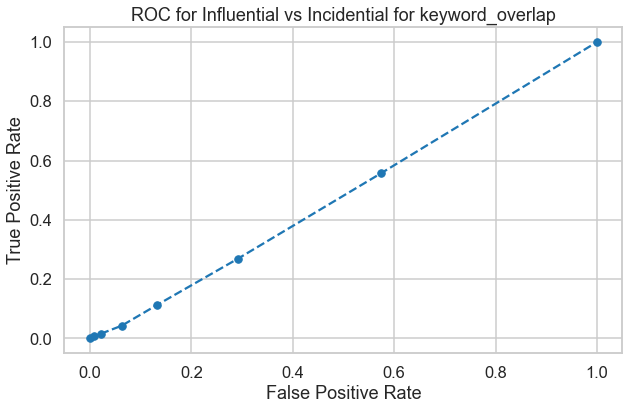

In [162]:
# Import sklearn ROC feature to make for rapid computing
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_true, y_score/sum(y_score))

# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential for keyword_overlap")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.show()

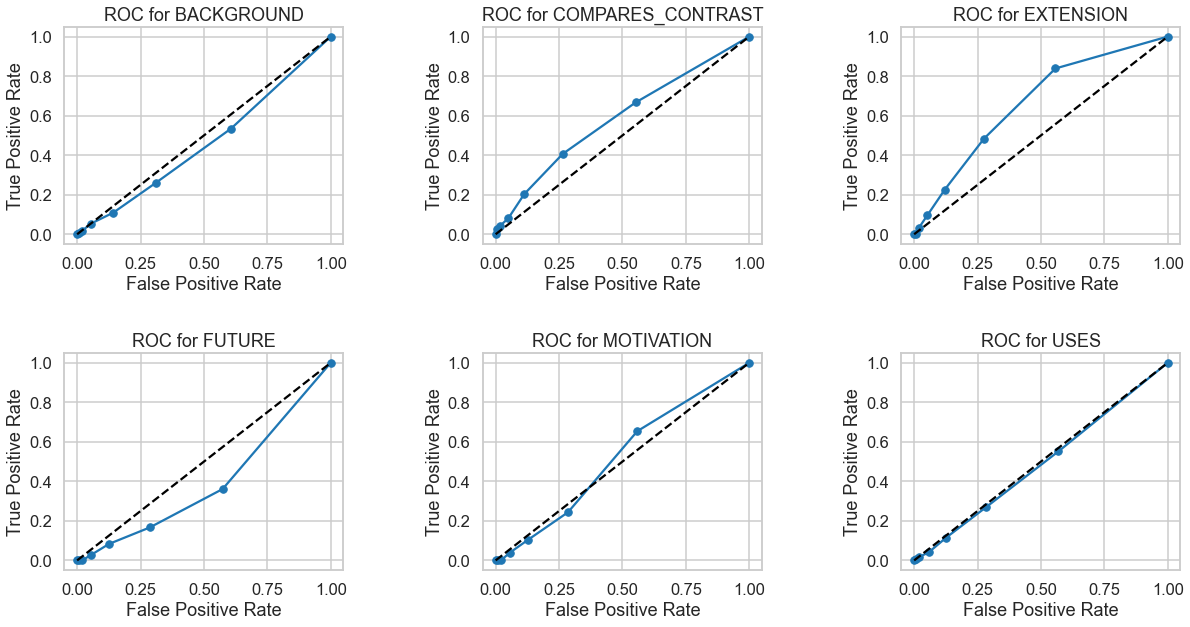

In [226]:
# Now for the multiclass
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    # Treat each as a one vs all classificaiton problem for each class
    y_true = (title_df["citation_class_label"] == i).astype(int).to_numpy()
    y_score = title_df["keyword_overlap"].to_numpy()
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, y_score/sum(y_score))
    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

## Number of Verbs and Verb Tense

The next feature to analyze is the number of verbs and verb tense in the citation context to analyze how this relates to any of our classes.

In [241]:
def count_verbs(context):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if "VB" in tag[1]:
            verb_count += 1
    
    return verb_count

In [254]:
# Create a new column in the dataframe to store the num verbs feature
df["num_verbs"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citation context
    context = df.iloc[row]["citation_context"]
    
    # Compute the verb count
    verb_count = count_verbs(context)
    
    # Count the overlap
    df.at[row,"num_verbs"] = verb_count

#### Analyzing the Strength of the Features

We repeat our analysis from before.

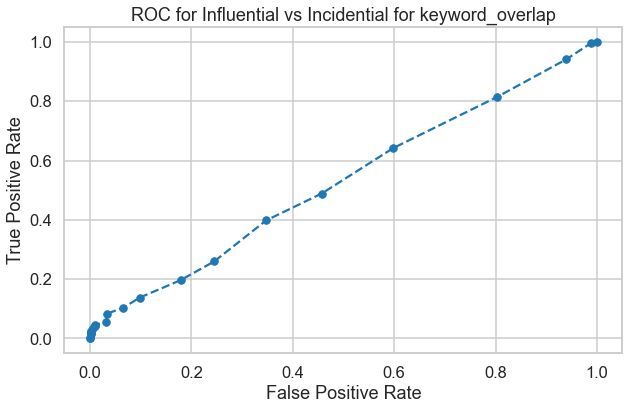

In [255]:
# Import sklearn ROC feature to make for rapid computing
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# Convert both features to numpy arrays for ease of use
y_score = df["num_verbs"].to_numpy()
y_true = df["citation_influence_label"].to_numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_score/sum(y_score))

# Plot the curve
plt.figure(figsize = (10,6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Influential vs Incidential for keyword_overlap")
plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
plt.show()

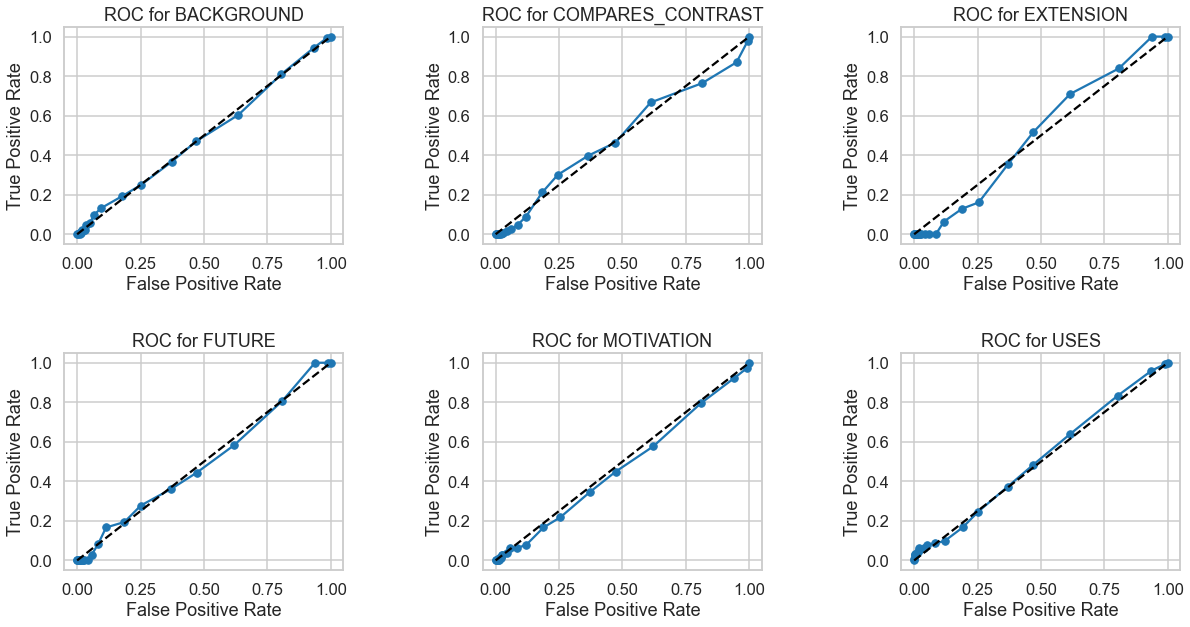

In [256]:
# Now for the multiclass
class_labels = ["BACKGROUND", "COMPARES_CONTRAST", "EXTENSION", "FUTURE", "MOTIVATION", "USES"]

fig, axs = plt.subplots(2,3, figsize = (20,10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
# Iterate through all the class labels
for i in range(0,6):
    # Treat each as a one vs all classificaiton problem for each class
    y_true = (df["citation_class_label"] == i).astype(int).to_numpy()
    y_score = df["num_verbs"].to_numpy()
    
    # Compute the fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_true, y_score/sum(y_score))
    
    # Plot the curve
    ax = axs.flat[i]
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC for {class_labels[i]}")
    ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
    ax.plot([0,1],[0,1], linestyle = "--", c = "k")
plt.show()

# Verb Tense

Same analysis as before but now we consider the tense of each specific verb.

In [257]:
def count_verbs_tense(context, tense):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if tense in tag[1]:
            verb_count += 1
    
    return verb_count

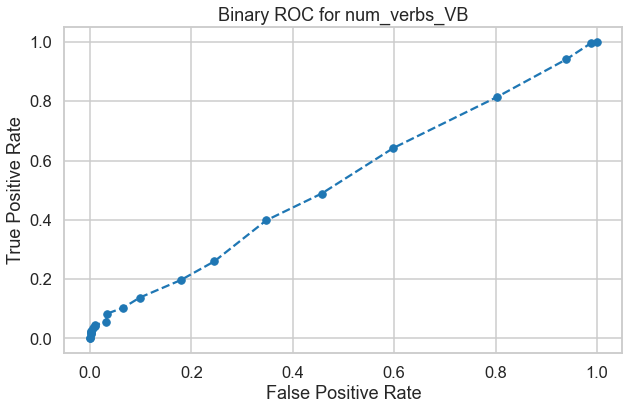

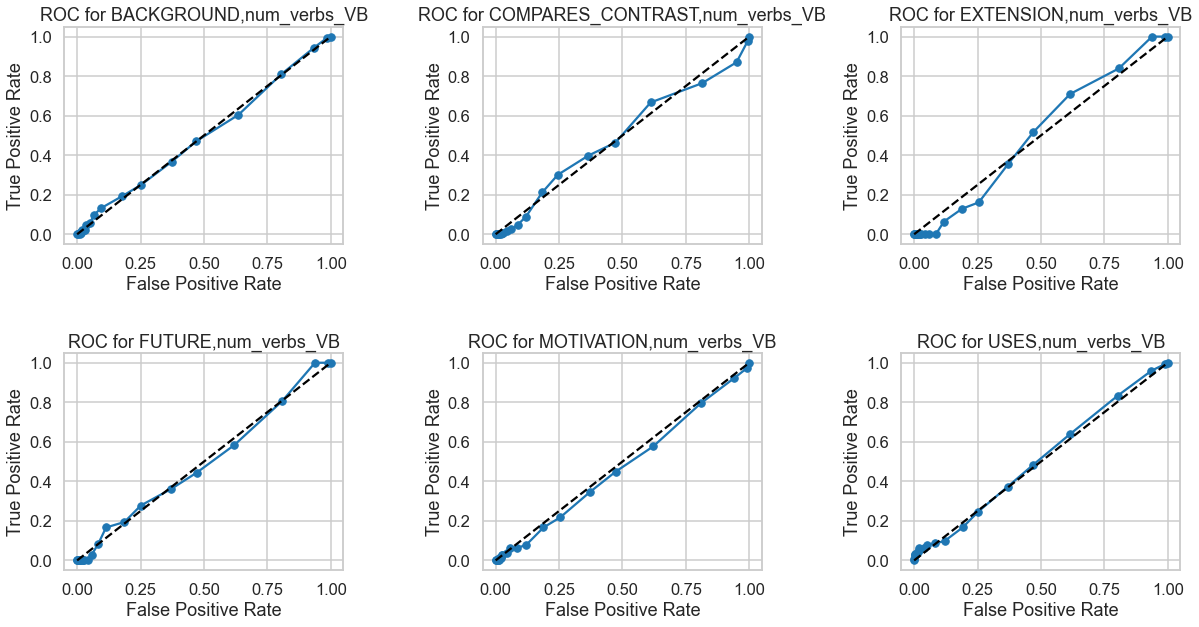

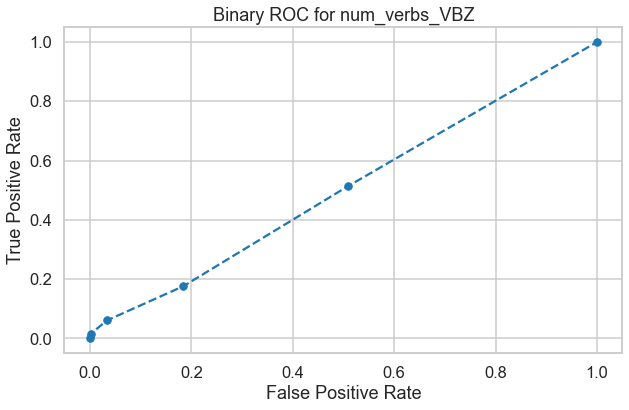

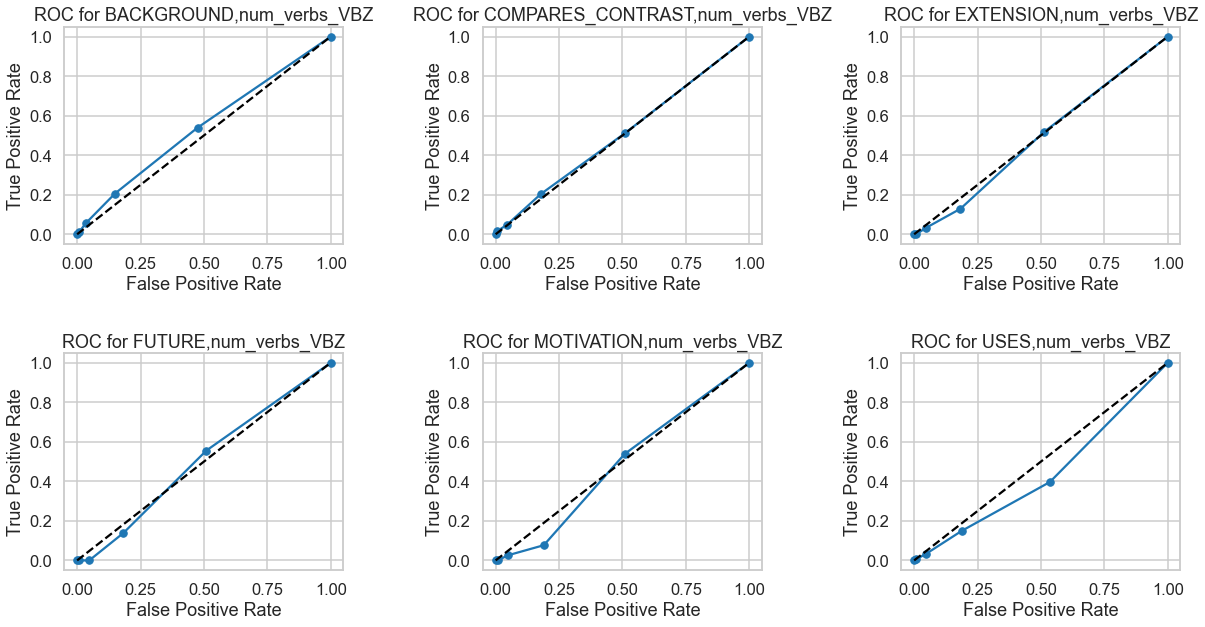

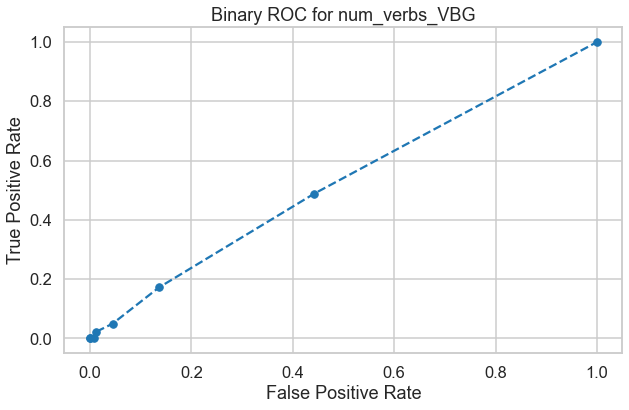

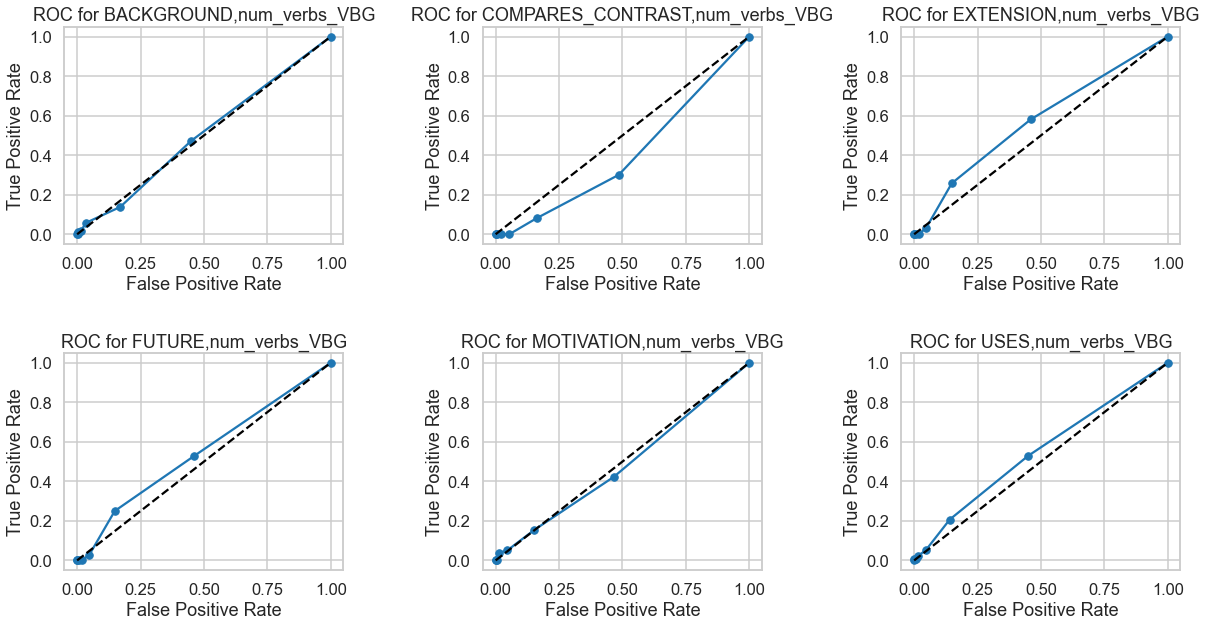

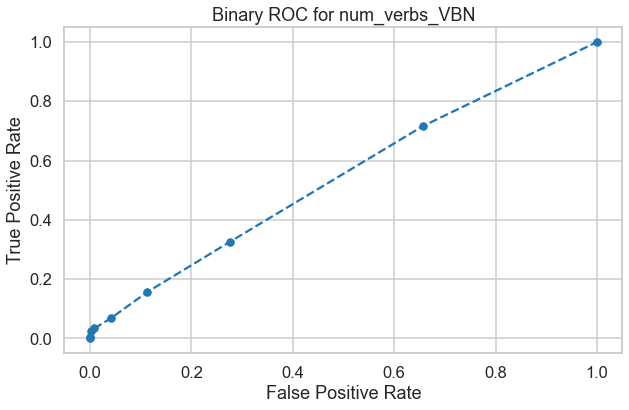

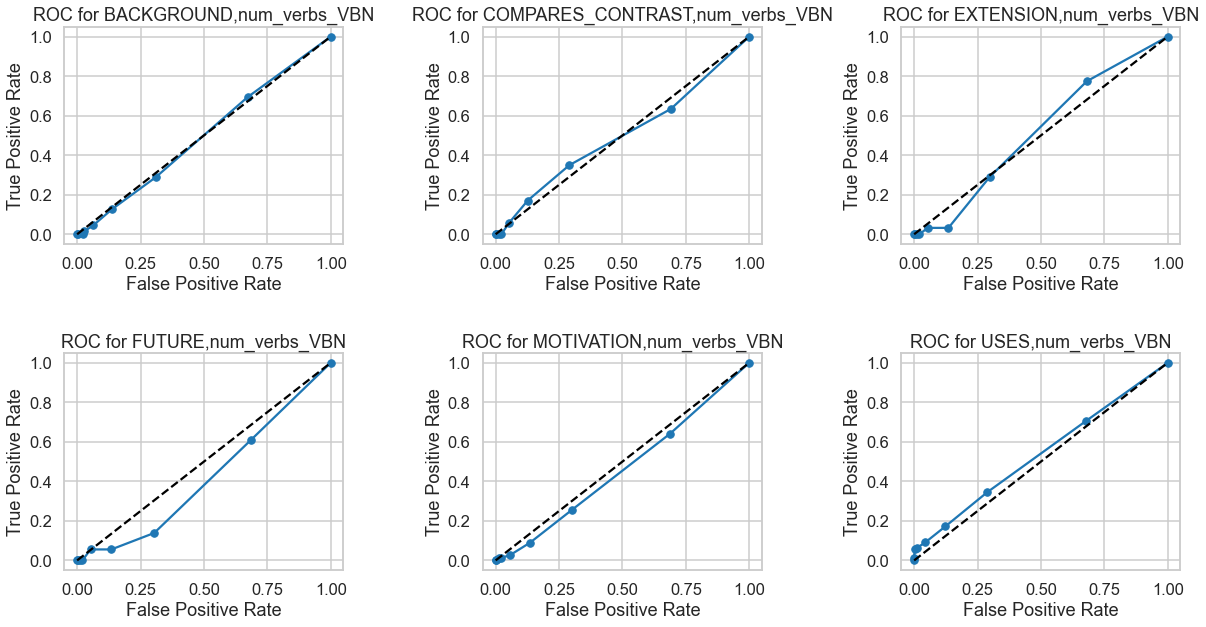

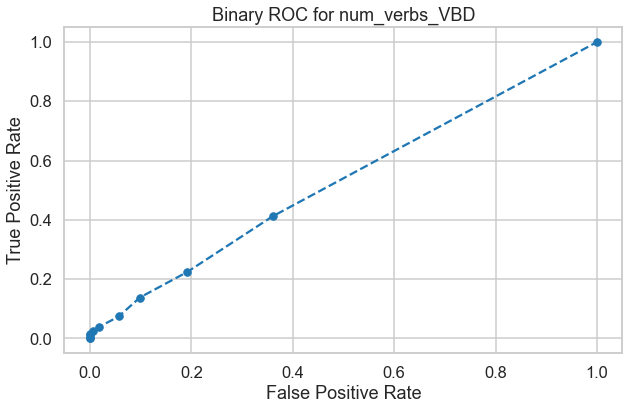

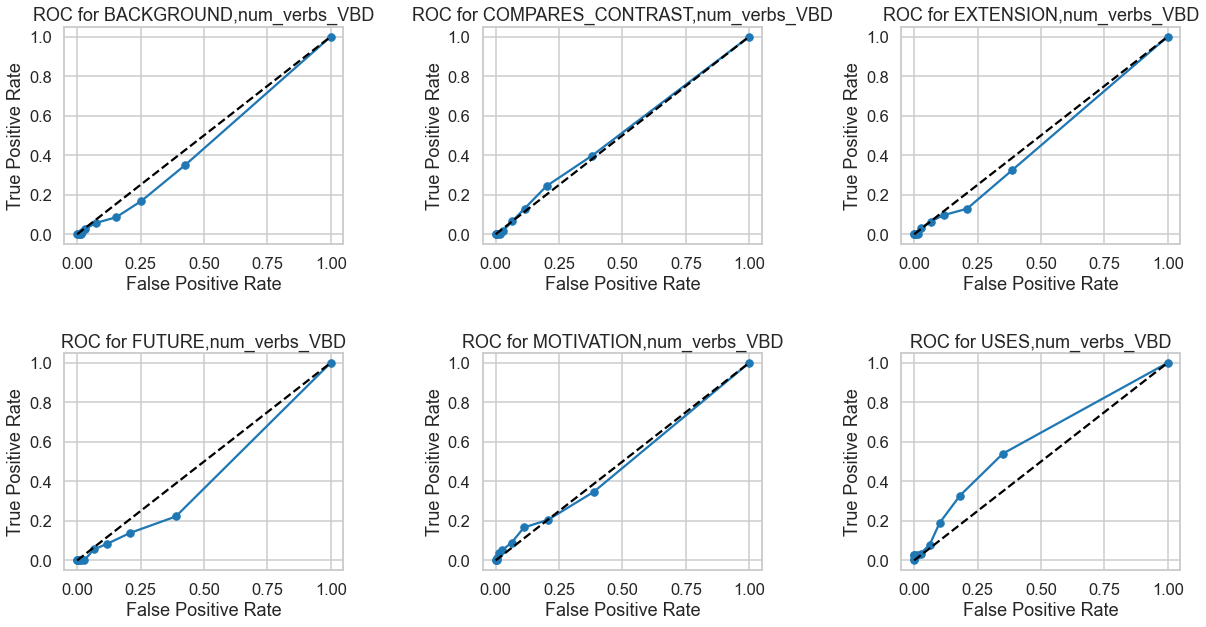

In [258]:
tenses = ["VB","VBZ", "VBG", "VBN", "VBD"]
for tense in tenses:
    # Create feature
    feature_name = f"num_verbs_{tense}"
    df[feature_name] = np.zeros(df.shape[0])

    # Traverse through all the rows of the dataframe and generate the new feature
    for row in df.index:
        # Grab the citation context
        context = df.iloc[row]["citation_context"]

        # Compute the verb count
        verb_count = count_verbs_tense(context, tense)

        # Count the overlap
        df.at[row,feature_name] = verb_count
    
    # Analyze Binary
    # Convert both features to numpy arrays for ease of use
    y_score = df[feature_name].to_numpy()
    y_true = df["citation_influence_label"].to_numpy()

    fpr, tpr, thresholds = roc_curve(y_true, y_score/sum(y_score))

    # Plot the curve
    plt.figure(figsize = (10,6))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Binary ROC for {feature_name}")
    plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
    plt.show()
    
    fig, axs = plt.subplots(2,3, figsize = (20,10))
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    # Iterate through all the class labels
    for i in range(0,6):
        # Treat each as a one vs all classificaiton problem for each class
        y_true = (df["citation_class_label"] == i).astype(int).to_numpy()
        y_score = df[feature_name].to_numpy()

        # Compute the fpr and tpr
        fpr, tpr, thresholds = roc_curve(y_true, y_score/sum(y_score))

        # Plot the curve
        ax = axs.flat[i]
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC for {class_labels[i]},{feature_name}")
        ax.plot(fpr, tpr, linestyle = "-", marker = ".",  markersize = 15)
        ax.plot([0,1],[0,1], linestyle = "--", c = "k")
    plt.show()

#### Verb Content Analysis

While we'll here, let's see what the most common verbs are in each label. Let's start with influential vs incidental.

In [308]:
# Grab all influential

def count_all_verb_types(arg_df):
    # Verb types array
    verb_types = ["VB","VBZ","VBN","VBG","VBD"]

    # Store all verbs and their occurrence in a hashmap
    verb_counter = {}
    for verb_type in verb_types:
        verb_counter[verb_type] = 0

    for row in range(arg_df.shape[0]):
        # Grab the citation context
        context = arg_df.iloc[row]["citation_context"]

        # Breakup the words into tokens
        context_words = word_tokenize(context)
        tags = nltk.pos_tag(context_words)

        # Update counts
        for tag in tags:
            pos = tag[1]
            if pos in verb_types:
                verb_counter[pos] += 1
                
    return verb_counter

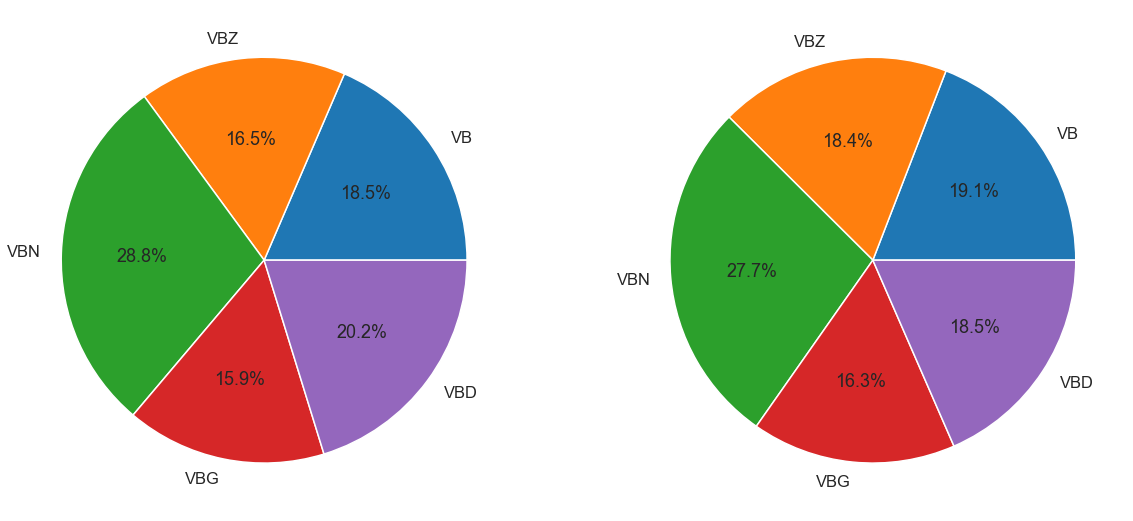

In [309]:
inf_df = df[df["citation_influence_label"] == 1]
verb_counter = count_all_verb_types(inf_df)

fig, ax = plt.subplots(1,2, figsize = (20,10))
ax.flat[0].pie(verb_counter.values(), labels= verb_counter.keys(), autopct = '%1.1f%%')

inf_df = df[df["citation_influence_label"] == 0]
verb_counter = count_all_verb_types(inf_df)

ax.flat[1].pie(verb_counter.values(), labels= verb_counter.keys(), autopct = '%1.1f%%')
plt.show()

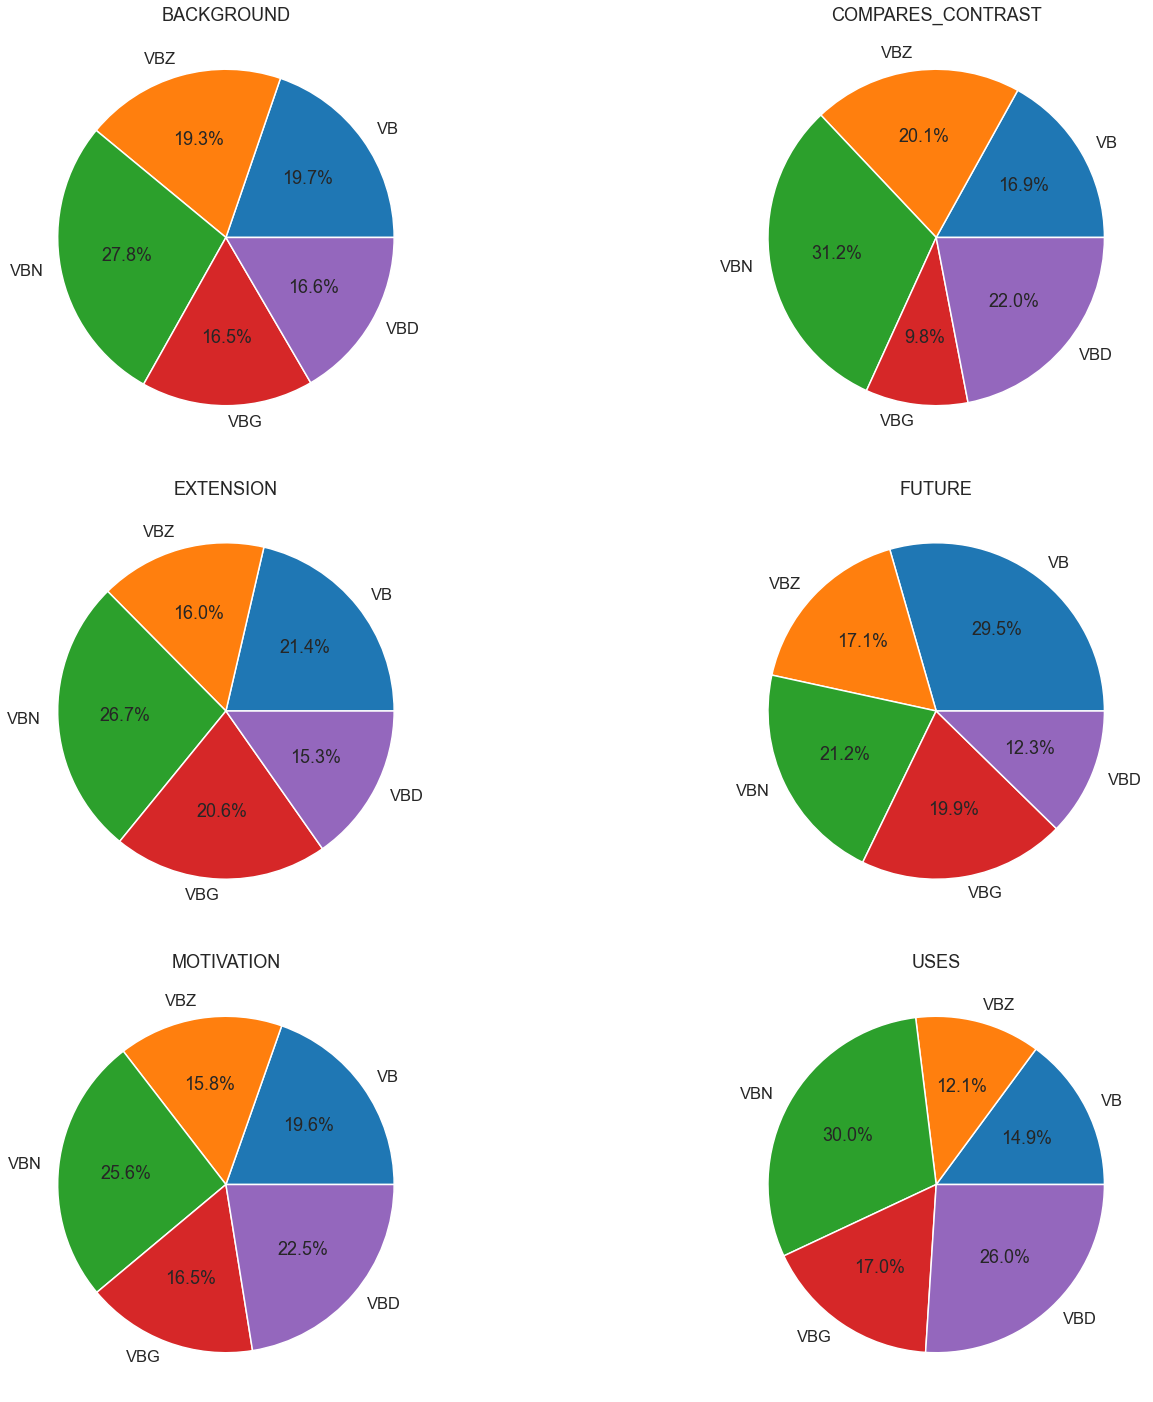

In [310]:
fig, ax = plt.subplots(3,2, figsize =(20,20))
fig.tight_layout()
for i in range(6):
    inf_df = df[df["citation_class_label"] == i]
    verb_counter = count_all_verb_types(inf_df)

    ax.flat[i].pie(verb_counter.values(), labels= verb_counter.keys(), autopct = '%1.1f%%')
    ax.flat[i].set_title(class_labels[i])
plt.show()

## Searching for Time Relative Adverbs

Let's now look for specific adverbs which are known to designate some kind of temporal structure.

In [326]:
adverbs = ["historically", "previously", "shown", "proposed", "propose "]
for adverb in adverbs:
    sub_df = df[df["citation_context"].str.contains(adverb)]
    display(sub_df[["citation_context","citation_class_label","citation_influence_label"]])

Empty DataFrame
Columns: [citation_context, citation_class_label, citation_influence_label]
Index: []

citation_context  citation_class_label  \
61   For example, one study explored the introducti...                     3   
140  libellula) have previously been demonstrated f...                     0   
218  No estimates of the prevalence of MS in BC usi...                     5   
219  No estimates of the prevalence of MS in BC usi...                     5   
465  Four years previously, he was diagnosed with l...                     0   
579  Parallels between linguistic grammar and ritua...                     0   
816  However, the number of observations left for a...                     0   
903  Psychopharmaceuticals themselves are circulati...                     0   
974  The brain activations related to these tasks h...                     5   

     citation_influence_label  
61                          0  
140                         0  
218                         1  
219                         1  
465                         1  
579                         0  
816                         0  
903                         0  
974                         0

citation_context  citation_class_label  \
40   DiscussionIt has been shown in [4], #AUTHOR_TA...                     0   
42   Yet, peer review has been shown by #AUTHOR_TAG...                     0   
43   Yet, peer review has been shown by [16], #AUTH...                     0   
44   Yet, peer review has been shown by [16], [17] ...                     0   
75   Previous research has shown that just because ...                     0   
79   The patients in this trial were treated with 3...                     1   
156  #AUTHOR_TAG Research question 2: What are the ...                     4   
315  To take the DICE model as an example (#AUTHOR_...                     5   
543  The SDQ was extended to include questions aski...                     0   
601  Since then, further work has shown that MEP yi...                     0   
602  Due to the competition of work extraction from...                     5   
609  Due to the competition of work extraction from...                     5   
667  A simple model based upon excluded volume theo...                     5   
683  However, it is a common experience that protei...                     0   
684  However, it is a common experience that protei...                     0   
685  However, it is a common experience that protei...                     0   
704  It has been shown that as the number of social...                     0   
762  If  tends to 1 (which amounts to say that call...                     1   
789  While several studies have found that 2-6 days...                     2   
798  While several studies have found that 2-6 days...                     1   
812  While several studies have found that 2-6 days...                     1   
813  While several studies have found that 2-6 days...                     1   
816  However, the number of observations left for a...                     0   
878  As STS scholars have shown, publics can be bot...                     0   
889  As STS scholars have shown, publics can be bot...                     3   
893  This has long been a concern of STS scholars, ...                     0   
901  For example, #AUTHOR_TAG has shown how moral q...                     0   
904  Casting New LightIn regards to the former, met...                     0   
982  In the same way that visual imagery and visual...                     0   
989  In the same way that visual imagery and visual...                     0   

     citation_influence_label  
40                          0  
42                          0  
43                          0  
44                          0  
75                          0  
79                          0  
156                         1  
315                         1  
543                         0  
601                         0  
602                         1  
609                         1  
667                         1  
683                         0  
684                         1  
685                         1  
704                         0  
762                         1  
789                         1  
798                         0  
812                         0  
813                         0  
816                         0  
878                         1  
889                         1  
893                         0  
901                         0  
904                         1  
982                         0  
989                         0

citation_context  citation_class_label  \
203  #AUTHOR_TAG, the original proponent of the JIF...                     0   
316  A recent paper by Ackerman and Stanton (2011) ...                     5   
355  Here is an open conjecture (a preliminary vers...                     1   
563  A competing account has recently been proposed...                     0   
606  These processes generally operate away from a ...                     0   
610  To characterize the organization of the steady...                     0   
612  To characterize the organization of the steady...                     0   
613  To characterize the organization of the steady...                     0   
614  To characterize the organization of the steady...                     0   
615  To characterize the organization of the steady...                     0   
616  To characterize the organization of the steady...                     0   
674  There have been many hypotheses proposed relat...                     0   
756  This concept was first proposed by #AUTHOR_TAG...                     5   

     citation_influence_label  
203                         0  
316                         1  
355                         0  
563                         1  
606                         1  
610                         1  
612                         1  
613                         1  
614                         1  
615                         1  
616                         1  
674                         0  
756                         1

citation_context  citation_class_label  \
5  #AUTHOR_TAG propose a hybrid recommendation mo...                     1   
6  #AUTHOR_TAG propose RecomMetz, a context-aware...                     1   

   citation_influence_label  
5                         0  
6                         0